<a href="https://colab.research.google.com/github/faizanahemad/data-science-utils/blob/master/data_science_utils/vision/keras/GradCam_with_misclassified_LRFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we show how to 

- Base Net: SGD+momentum+cutout
- Use LRFinder
- Use SGD with LR found by LR Finder
- Using LR Scheduler
- Gradcam with misclassified examples using ImageDataGenerator
- Gradcam with correctly classified examples using ImageDataGenerator

We will show how each of these steps gives improvement by doing it in gradual steps. As usual do remember to [Star my Repo](https://github.com/faizanahemad/data-science-utils)

[Code for LR Finder](https://github.com/faizanahemad/data-science-utils/blob/master/data_science_utils/vision/keras/lr_finder.py)



# Imports

In [1]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-hxp38bpq


In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
import numpy as np
import cv2

import gc

InteractiveShell.ast_node_interactivity = "all"


Using TensorFlow backend.


In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [0]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()



cutout_fn = get_cutout_eraser(p=0.75, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                           preprocessing_function=cutout_fn)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen_validation.fit(X_train)

def denormalize(img):
  return (img*datagen_validation.std + datagen_validation.mean)/255

# Model Functions

In [0]:
def build_model(lr=0.01,base=8):
  inputs = Input(shape=(32,32,3))
  
  # 1st BLOCK
  x = conv_layer(inputs,name="c1",n_kernels=base*8, padding='same',kernel_size=(5, 5))
  x = conv_layer(x,name="c3",n_kernels=base*9, padding='same', spatial_dropout=0.05)
  x = conv_layer(x,name="c4",n_kernels=base*10, padding='same', spatial_dropout=0.1)
  x = MaxPooling2D()(x) 
  
  
  x1 = transition_layer(x,"tran_1", base*6)

  
  # 2nd BLOCK
  x = conv_layer(x,name="c5_1",n_kernels=base*6, padding='same')
  x = conv_layer(x,name="c5",n_kernels=base*7, padding='same')
  x = conv_layer(x,name="c6",n_kernels=base*8, padding='same')
  x = conv_layer(x,name="c7",n_kernels=base*9, padding='same', spatial_dropout=0.05)
  x2 = transition_layer(x,"tran_3", base*6)
  x = MaxPooling2D()(x) # 8
  
  
  # 3rd BLOCK
  print("Concat: Shape of 1st = %s, Shape of 2nd = %s"%(K.int_shape(x1),K.int_shape(x)))
  x = concat_s2d([x1,x])
  print("Shape after concat =",K.int_shape(x))
  print("="*80)
  x = conv_layer(x,name="c9",n_kernels=base*6, padding='same')
  x = conv_layer(x,name="c10",n_kernels=base*8, padding='same',spatial_dropout=0.05)
  x = conv_layer(x,name="c11",n_kernels=base*10, padding='same',spatial_dropout=0.1)
  
  print("Concat: Shape of 1st = %s, Shape of 2nd = %s"%(K.int_shape(x2),K.int_shape(x)))
  x = concat_s2d([x2,x])
  print("Shape after concat =",K.int_shape(x))
  print("="*80)
  
  out = transition_layer(x,"output_transition", base*8,bn=False)
  out = Conv2D(10,
          kernel_size=1,
          strides=1)(out)
  out = GlobalAveragePooling2D()(out)
  out = Activation("softmax")(out)
  
  model = Model(inputs=inputs, outputs=out)

  optimizer = SGD(lr=lr, decay=0, momentum=0.9, nesterov=True)


  model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])
  print("Model Params = ",model.count_params(), ", Metric Names = ",model.metrics_names)
  print("="*80)
  return model

In [0]:
def train_network(model,epochs=25, lr_scheduling_fn=None):
  
  
  datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
  datagen.fit(X_train)
  datagen_validation.fit(X_train)
  train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
  validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)
  checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  callbacks=[checkpoint]
  lr_schedule = LearningRateScheduler(lr_scheduling_fn) if lr_scheduling_fn is not None else None
  if lr_schedule is not None:
    callbacks.append(lr_schedule)
  train_history = model.fit_generator(train_iterator,
                      steps_per_epoch=len(train_iterator), 
                      validation_data = validation_iterator, 
                      validation_steps = len(validation_iterator),
                      epochs=epochs, verbose=0,callbacks=callbacks)
  
  model.load_weights("model.hdf5")
  iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
  score = model.evaluate_generator(iterator,steps=len(iterator))
  iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
  predictions = model.predict_generator(iterator,steps=len(iterator))
  _ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


  iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
  score = model.evaluate_generator(iterator,steps=len(iterator))
  iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
  predictions = model.predict_generator(iterator,steps=len(iterator))
  _ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)
  
  
  layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
  plot_model_history(train_history,clip_beginning=5)
  return train_history

# Base Model

In [14]:
model = build_model()

Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 72)
Shape after concat = (None, 8, 8, 264)
Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 80)
Shape after concat = (None, 8, 8, 272)
Model Params =  447506 , Metric Names =  ['loss', 'acc']


In [15]:
gc.collect()

276

 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.1539263059949875, 0.9845600000190735]
Balanced Accuracy = 98.46%, Accuracy = 98.46%
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.5385977581977844, 0.8716]
Balanced Accuracy = 87.16%, Accuracy = 87.16%


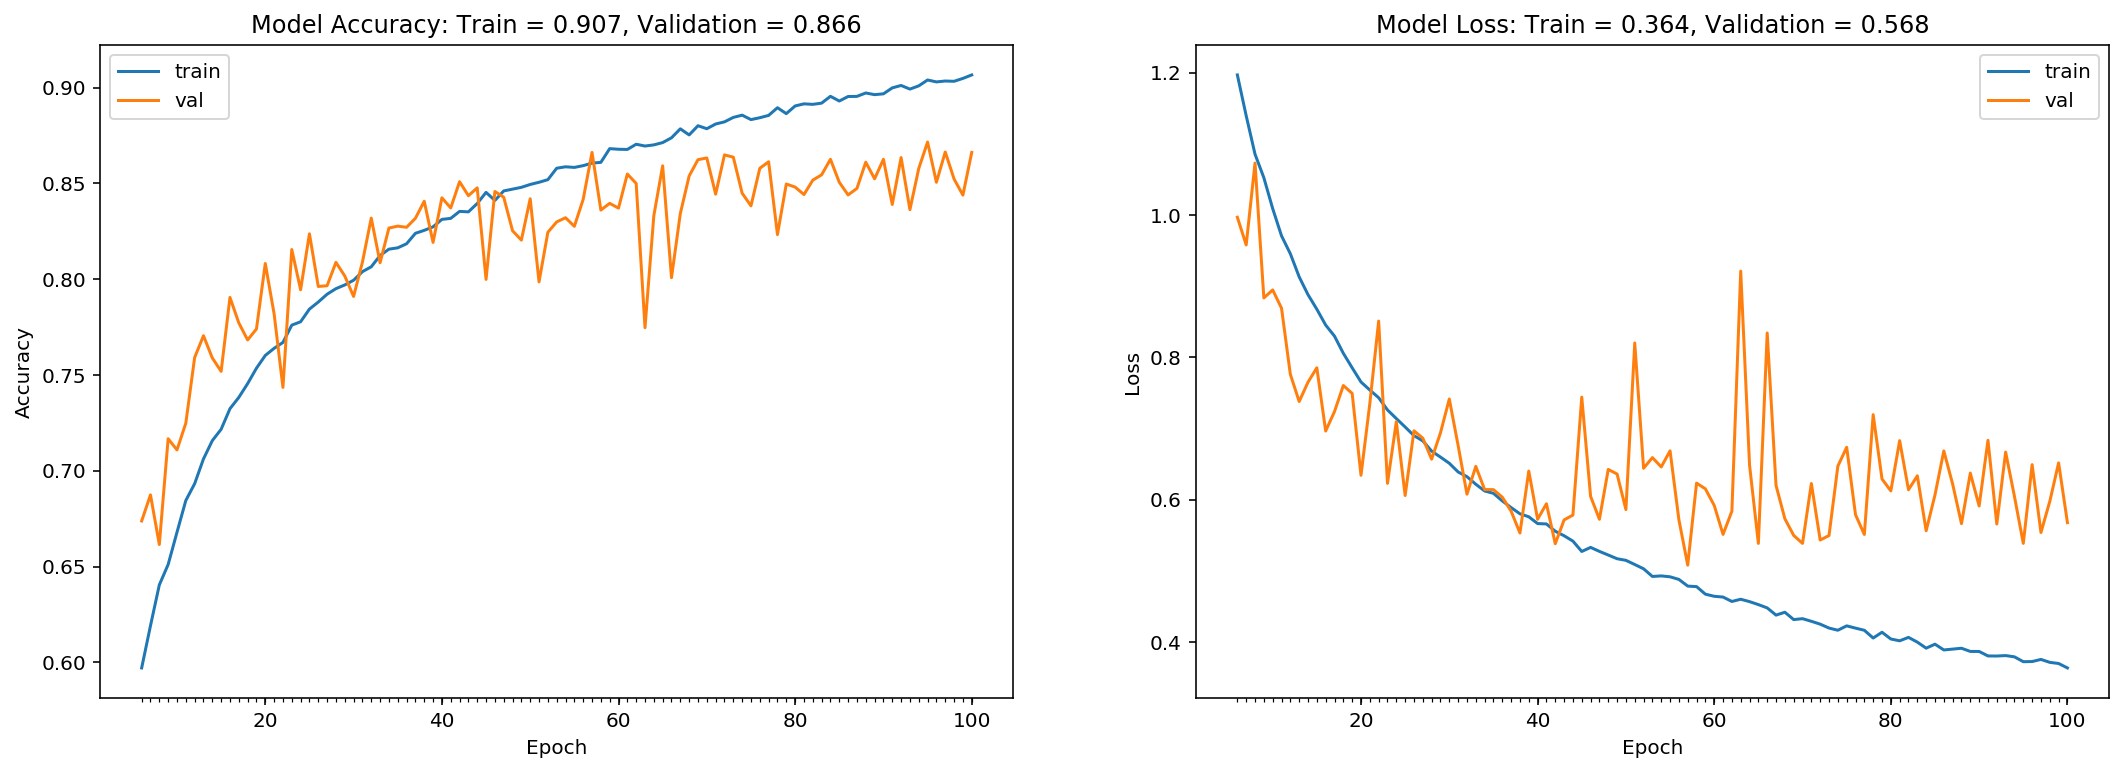

In [16]:
train_history = train_network(model,epochs=100,)

# LR Finder

In [30]:
model = build_model()

Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 72)
Shape after concat = (None, 8, 8, 264)
Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 80)
Shape after concat = (None, 8, 8, 272)
Model Params =  447506 , Metric Names =  ['loss', 'acc']


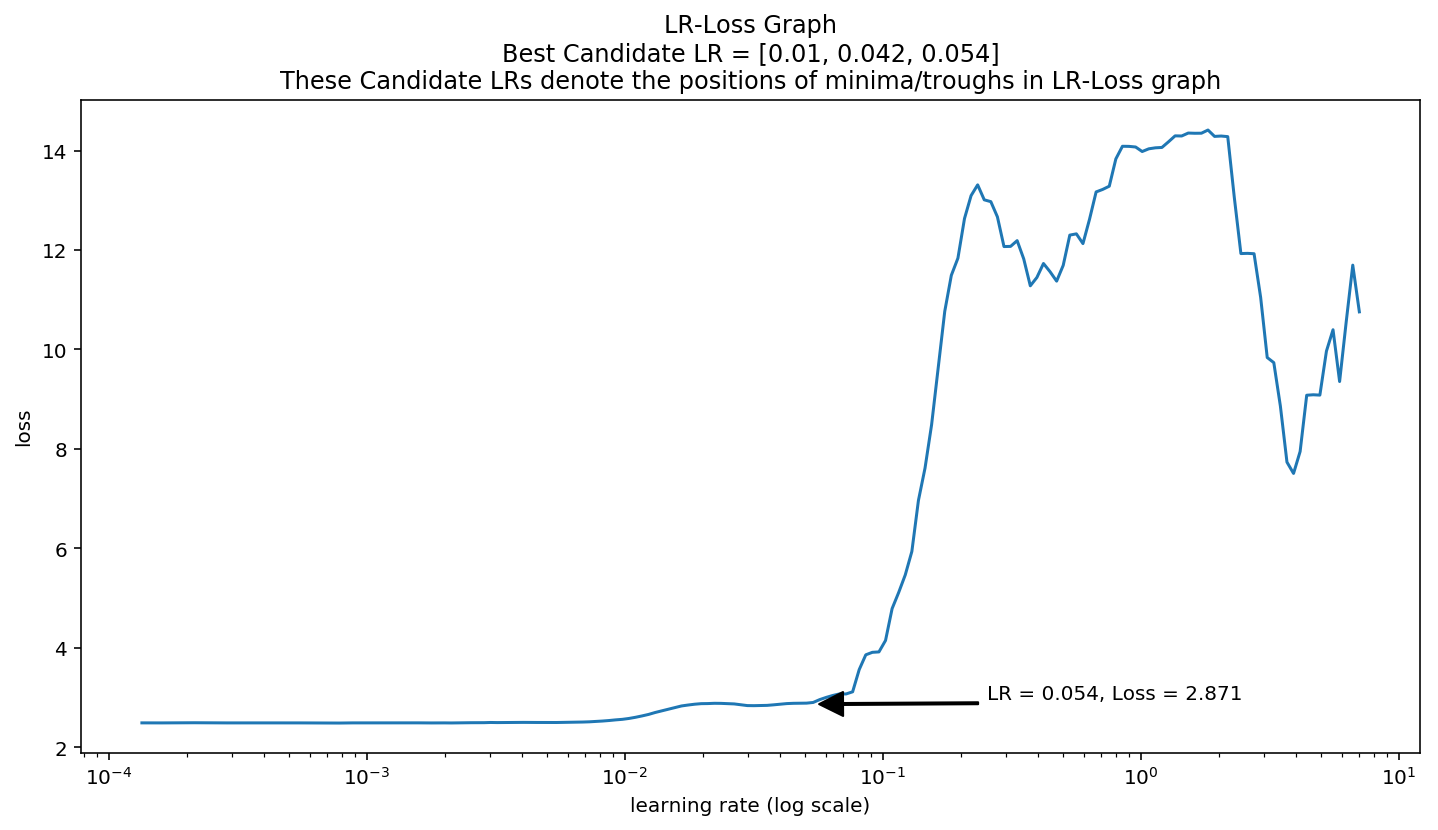

In [31]:
lrf = LRFinder(model)
generator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
test_generator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=True)
lrf.find_generator(generator, 0.0001, 10.0,test_generator, epochs=1, steps_per_epoch=None,)
lrf.plot_loss()

In [32]:
model = build_model(lr=0.05)

Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 72)
Shape after concat = (None, 8, 8, 264)
Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 80)
Shape after concat = (None, 8, 8, 272)
Model Params =  447506 , Metric Names =  ['loss', 'acc']


 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.2631522926902771, 0.972059999961853]
Balanced Accuracy = 97.21%, Accuracy = 97.21%
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.6249211067199707, 0.8701]
Balanced Accuracy = 87.01%, Accuracy = 87.01%


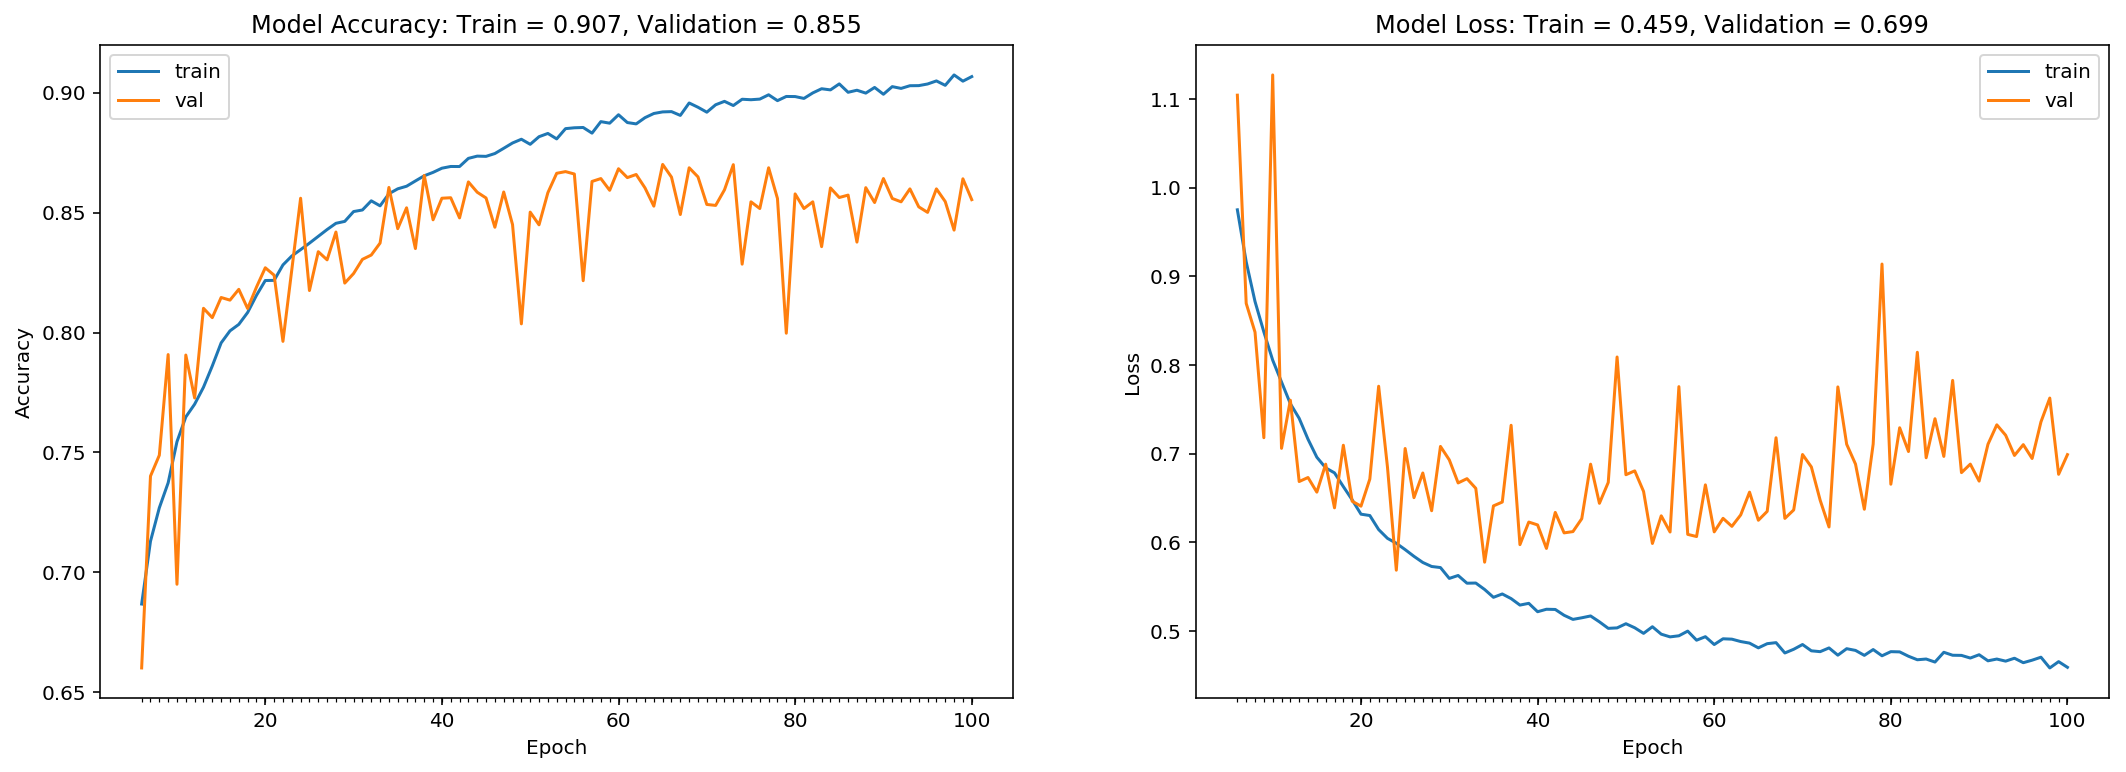

In [33]:
train_history = train_network(model,epochs=100,)


# LR Scheduling

In [34]:
model = build_model(lr=0.05)

Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 72)
Shape after concat = (None, 8, 8, 264)
Concat: Shape of 1st = (None, 16, 16, 48), Shape of 2nd = (None, 8, 8, 80)
Shape after concat = (None, 8, 8, 272)
Model Params =  447506 , Metric Names =  ['loss', 'acc']


 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.10801633776187897, 0.99948]
Balanced Accuracy = 99.95%, Accuracy = 99.95%
 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.5387346012115478, 0.8866]
Balanced Accuracy = 88.66%, Accuracy = 88.66%


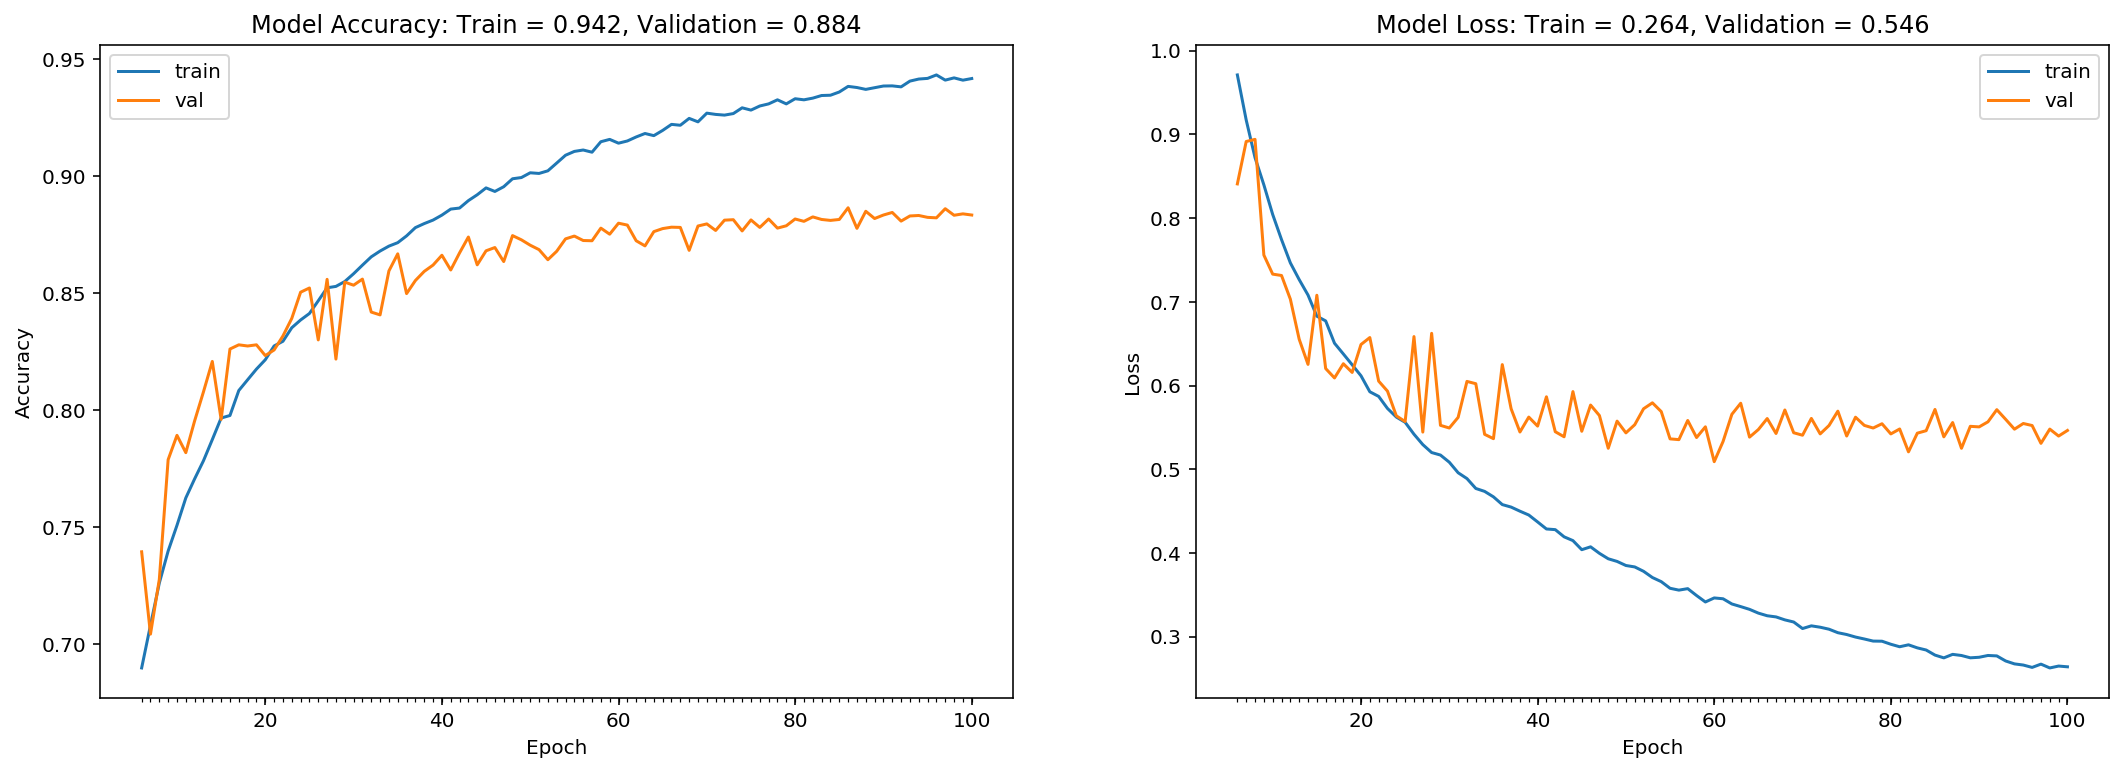

In [35]:
train_history = train_network(model,epochs=100,lr_scheduling_fn=lambda e,lr: 0.97*lr)

# GradCam

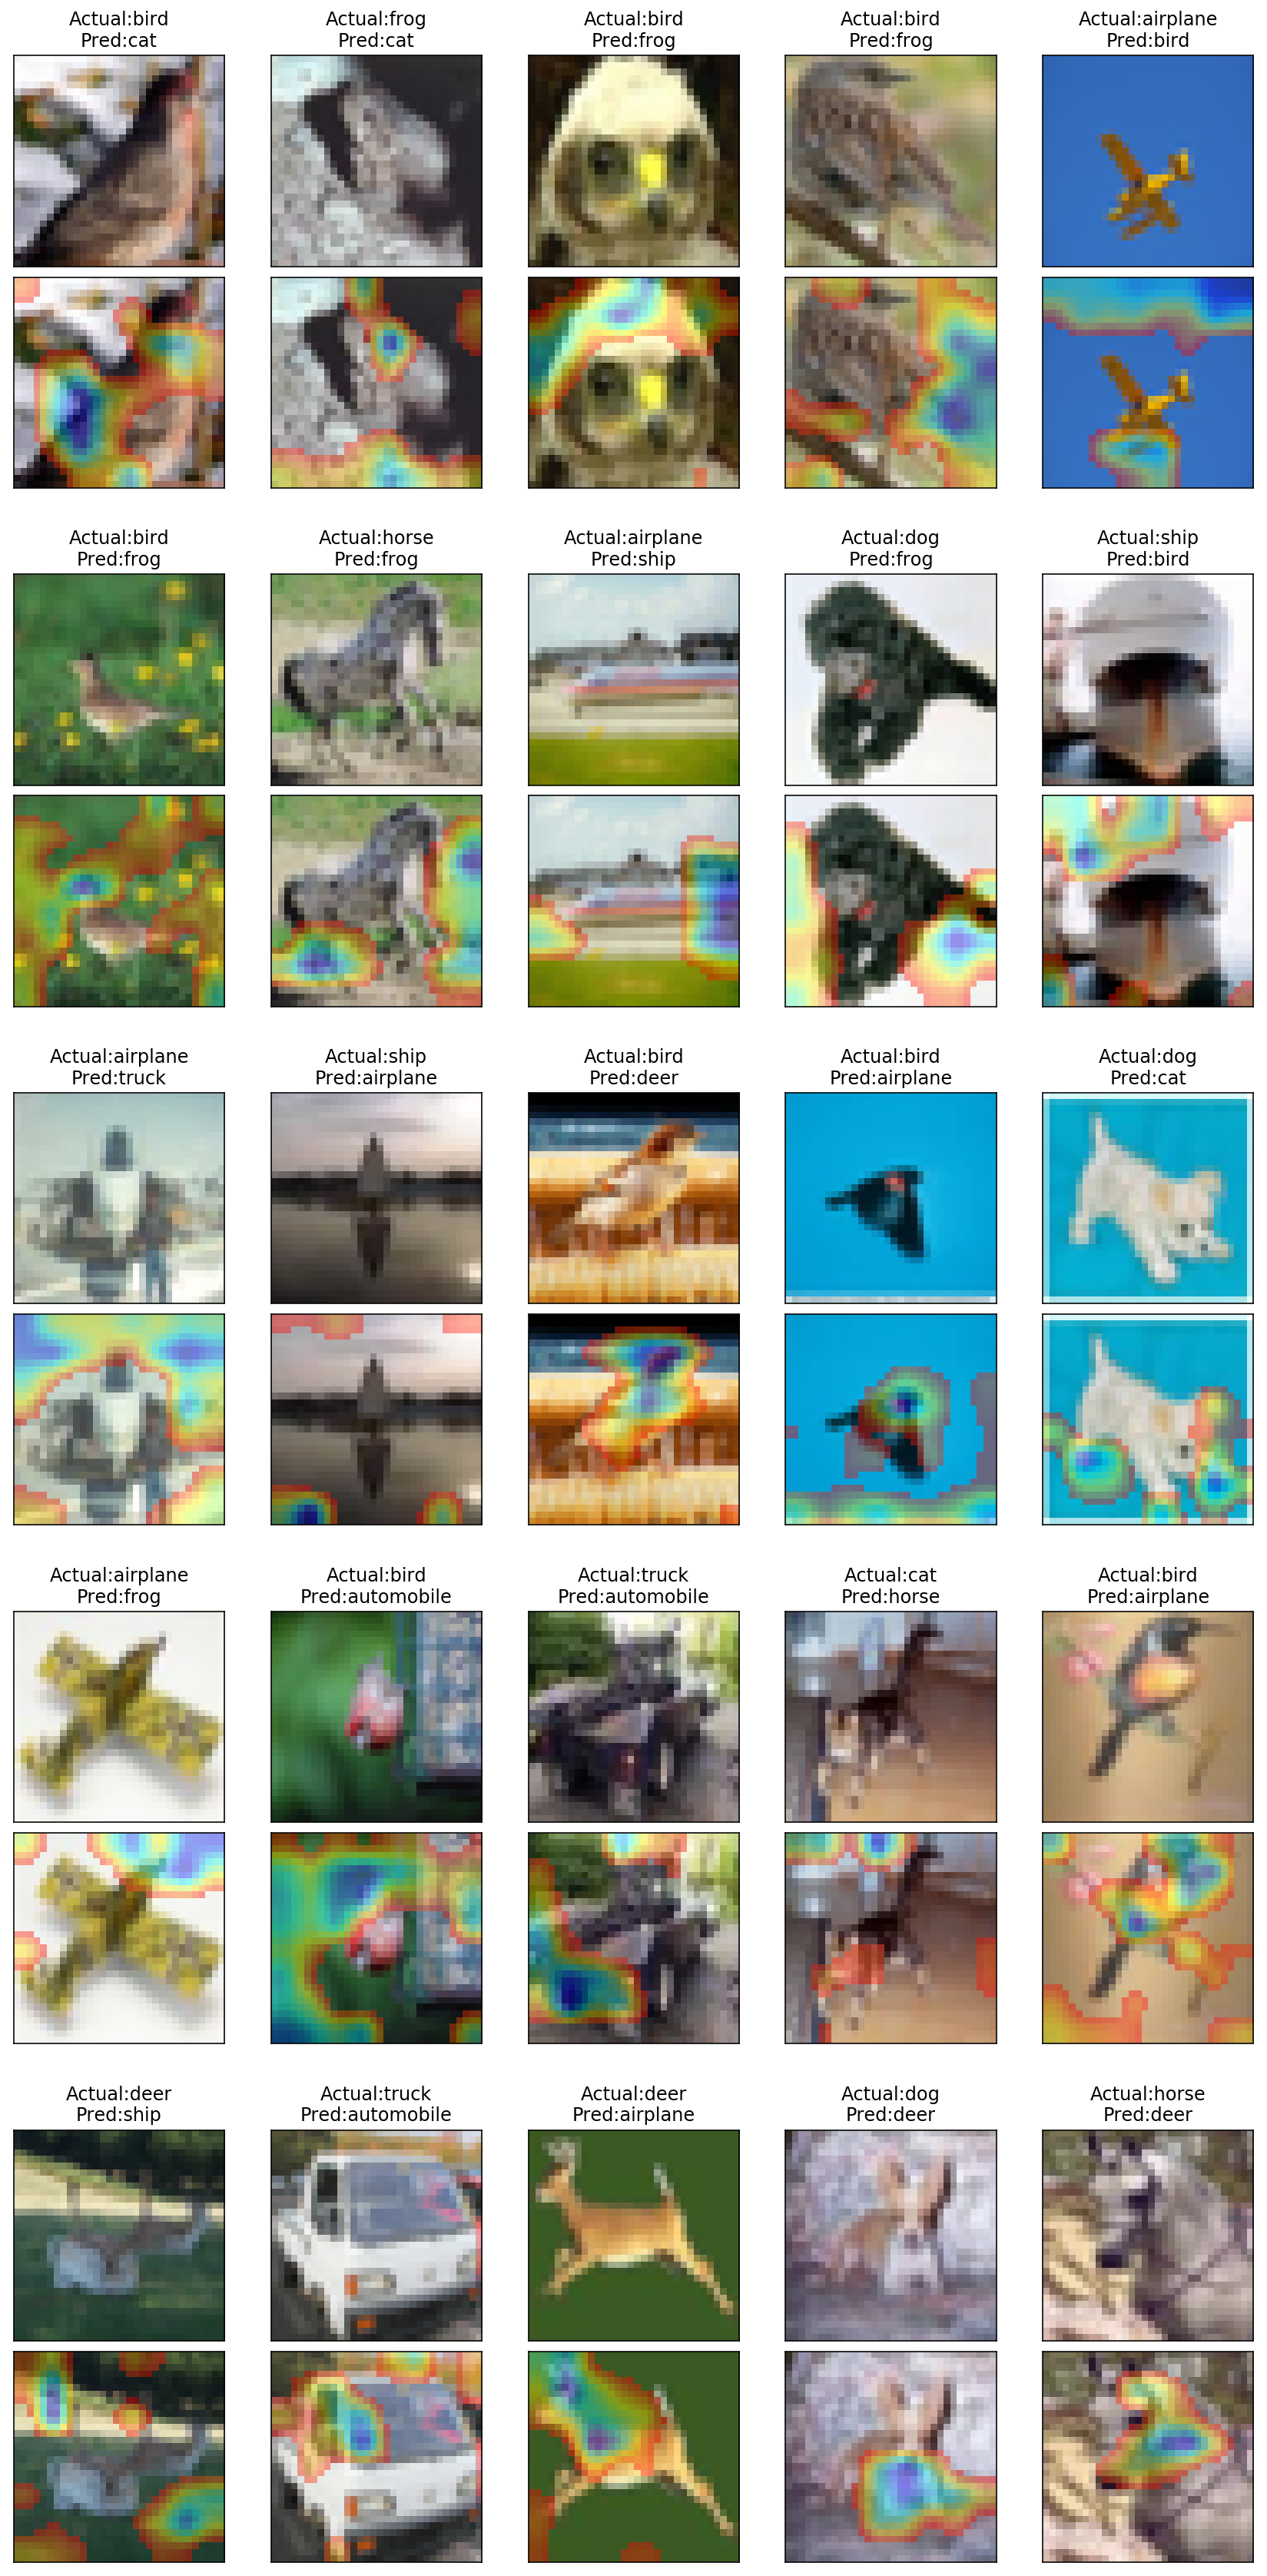

In [0]:
iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
show_misclassified_with_gradcam(model,"output_transition",iterator,classes=get_cifar10_labels(),preprocess_func=None,image_size_multiplier=3, examples=25,preprocess_img=denormalize)

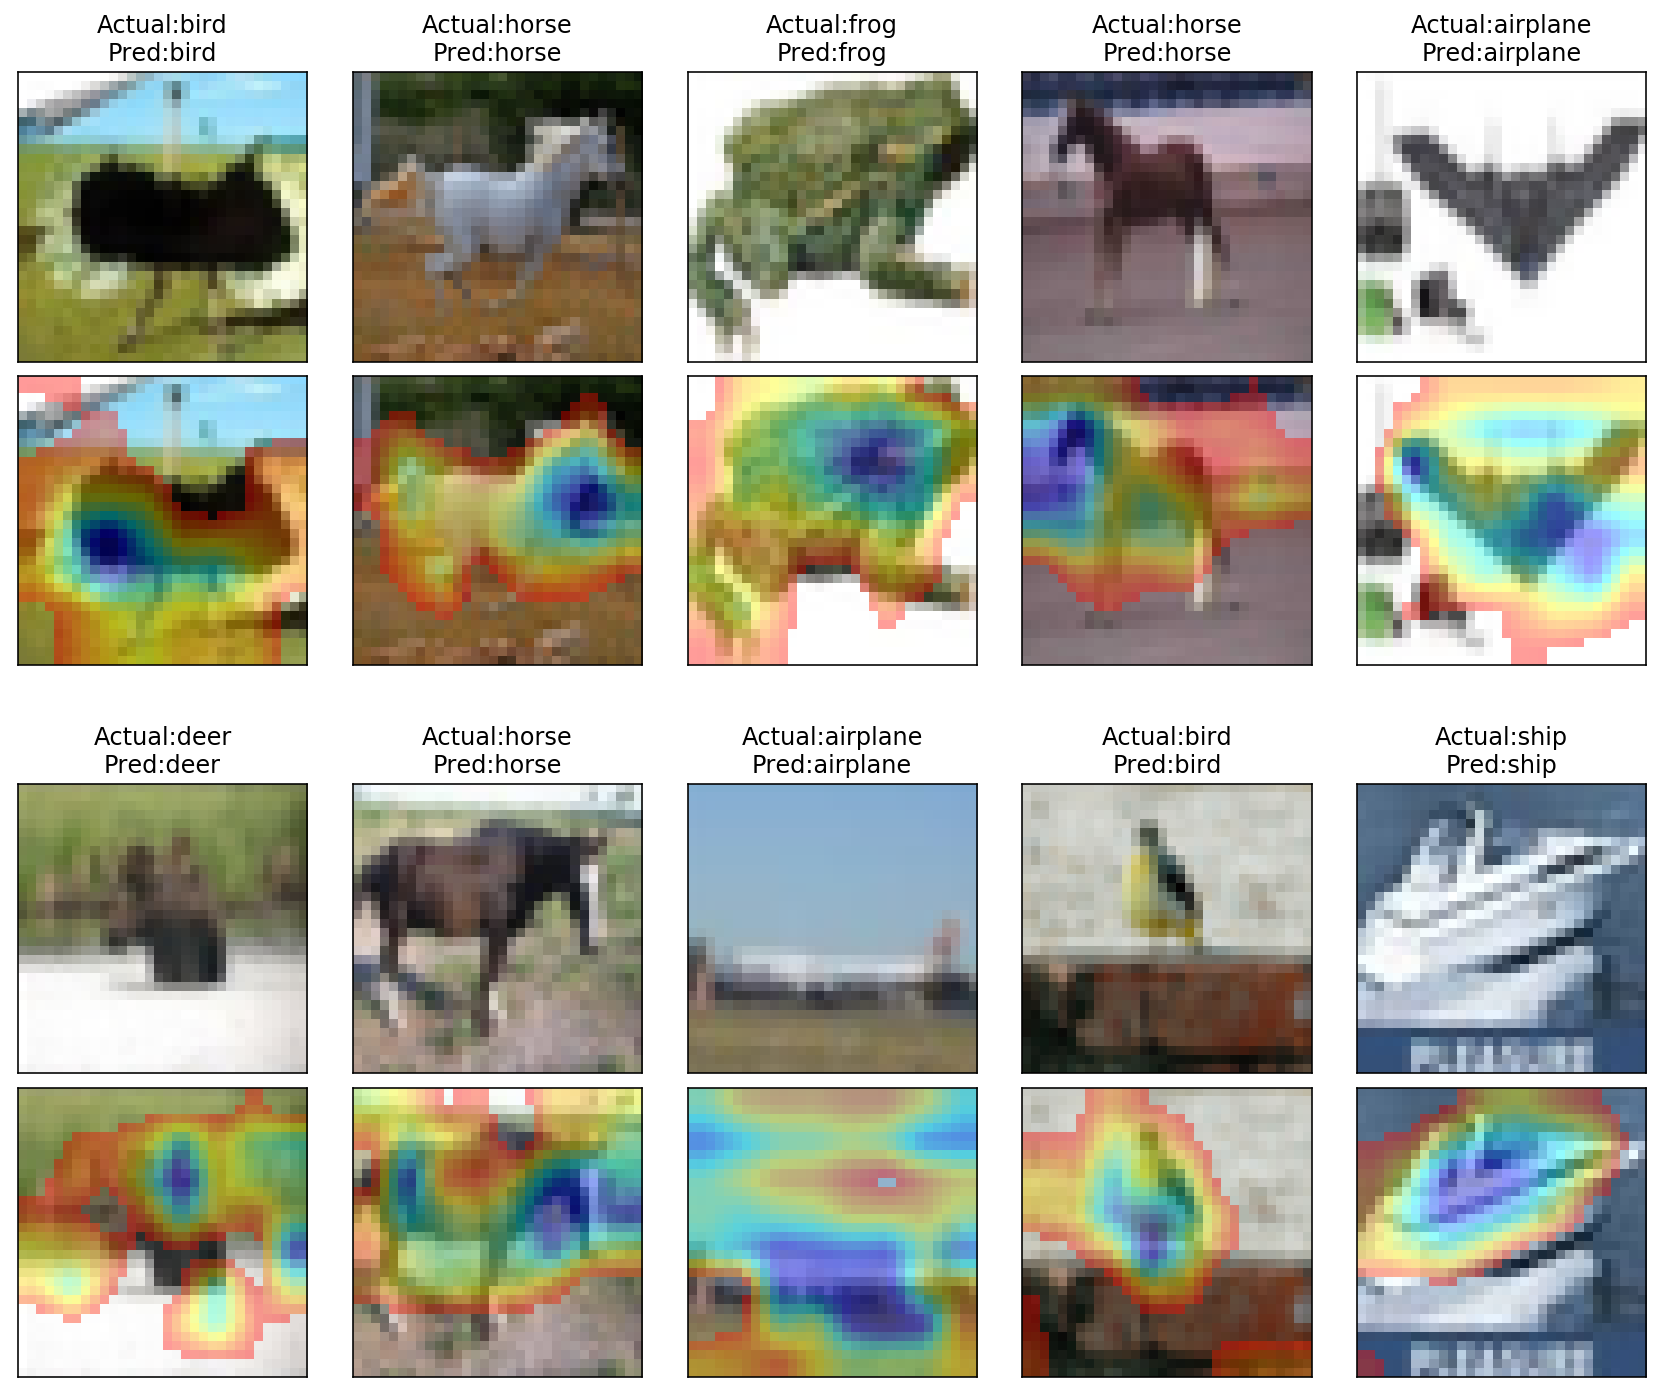

In [0]:
iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
show_correct_with_gradcam(model,"output_transition",iterator,classes=get_cifar10_labels(),preprocess_func=None,image_size_multiplier=3, examples=10,preprocess_img=denormalize)